In [1]:
!git clone https://github.com/sgrvinod/a-PyTorch-Tutorial-to-Image-Captioning

Cloning into 'a-PyTorch-Tutorial-to-Image-Captioning'...
remote: Enumerating objects: 255, done.
remote: Total 255 (delta 0), reused 0 (delta 0), pack-reused 255
Receiving objects: 100% (255/255), 12.88 MiB | 5.82 MiB/s, done.
Resolving deltas: 100% (139/139), done.
Checking connectivity... done.


In [2]:
!wget http://images.cocodataset.org/zips/train2014.zip

--2019-04-13 15:19:35--  http://images.cocodataset.org/zips/train2014.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.216.239.123
Connecting to images.cocodataset.org (images.cocodataset.org)|52.216.239.123|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13510573713 (13G) [application/zip]
Saving to: 'train2014.zip'

train2014.zip       100%[===================>]  12.58G  11.6MB/s    in 9m 0s   

2019-04-13 15:28:35 (23.8 MB/s) - 'train2014.zip' saved [13510573713/13510573713]



In [28]:
import shutil
shutil.move('/home/train2014','/home/a-PyTorch-Tutorial-to-Image-Captioning/data')


'/home/a-PyTorch-Tutorial-to-Image-Captioning/data/val2014'

In [31]:
shutil.move('/home/a-PyTorch-Tutorial-to-Image-Captioning/data/val2014','/home/a-PyTorch-Tutorial-to-Image-Captioning/data/train2014/val2014')

'/home/a-PyTorch-Tutorial-to-Image-Captioning/data/train2014/val2014'

In [22]:
!wget http://images.cocodataset.org/zips/val2014.zip

--2019-04-13 15:36:36--  http://images.cocodataset.org/zips/val2014.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.216.224.152
Connecting to images.cocodataset.org (images.cocodataset.org)|52.216.224.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6645013297 (6.2G) [application/zip]
Saving to: 'val2014.zip'

val2014.zip         100%[===================>]   6.19G  26.2MB/s    in 4m 21s  

2019-04-13 15:40:57 (24.3 MB/s) - 'val2014.zip' saved [6645013297/6645013297]



In [25]:
getdata.zipextract('./val2014.zip','/home')

In [3]:
!pip install -i https://test.pypi.org/simple/ supportlib
!wget https://cs.stanford.edu/people/karpathy/deepimagesent/caption_datasets.zip

import supportlib.gettingdata as getdata
getdata.zipextract('caption_datasets.zip')
getdata.zipextract('train2014.zip')

Looking in indexes: https://test.pypi.org/simple/
--2019-04-13 15:28:38--  https://cs.stanford.edu/people/karpathy/deepimagesent/caption_datasets.zip
Resolving cs.stanford.edu (cs.stanford.edu)... 171.64.64.64
Connecting to cs.stanford.edu (cs.stanford.edu)|171.64.64.64|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 36745453 (35M) [application/zip]
Saving to: 'caption_datasets.zip'

caption_datasets.zi 100%[===================>]  35.04M  10.2MB/s    in 3.4s    

2019-04-13 15:28:42 (10.2 MB/s) - 'caption_datasets.zip' saved [36745453/36745453]



In [6]:
!cd a-PyTorch-Tutorial-to-Image-Captioning


In [32]:
#!mkdir train
from utils import create_input_files
create_input_files(dataset='coco',
                       karpathy_json_path='/home/dataset_coco.json',
                       image_folder='/home/a-PyTorch-Tutorial-to-Image-Captioning/data',
                       captions_per_image=5,
                       min_word_freq=5,
                       output_folder='/home/a-PyTorch-Tutorial-to-Image-Captioning/train',
                       max_len=50)


RuntimeError: Unable to create link (name already exists)

In [16]:
import os()

/home


In [1]:
import os
os.chdir('/home/a-PyTorch-Tutorial-to-Image-Captioning')

In [10]:
from google_drive_downloader import GoogleDriveDownloader as gdd
gdd.download_file_from_google_drive(file_id='1FYZ446OPEqhe-uLkgyVICjD_3-N3IZn1',
                                    dest_path='/home/a-PyTorch-Tutorial-to-Image-Captioning/weigth.tar')

In [11]:
gdd.download_file_from_google_drive(file_id='1bt_TmTC_rUcss2MJsG_C_6DtwEttRVKc',
                                    dest_path='/home/a-PyTorch-Tutorial-to-Image-Captioning/word_map.json')

In [12]:
import torch
import torch.nn.functional as F
import numpy as np
import json
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import skimage.transform
import argparse
from scipy.misc import imread, imresize
from PIL import Image

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


def caption_image_beam_search(encoder, decoder, image_path, word_map, beam_size=3):
    """
    Reads an image and captions it with beam search.

    :param encoder: encoder model
    :param decoder: decoder model
    :param image_path: path to image
    :param word_map: word map
    :param beam_size: number of sequences to consider at each decode-step
    :return: caption, weights for visualization
    """

    k = beam_size
    vocab_size = len(word_map)

    # Read image and process
    img = imread(image_path)
    if len(img.shape) == 2:
        img = img[:, :, np.newaxis]
        img = np.concatenate([img, img, img], axis=2)
    img = imresize(img, (256, 256))
    img = img.transpose(2, 0, 1)
    img = img / 255.
    img = torch.FloatTensor(img).to(device)
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
    transform = transforms.Compose([normalize])
    image = transform(img)  # (3, 256, 256)

    # Encode
    image = image.unsqueeze(0)  # (1, 3, 256, 256)
    encoder_out = encoder(image)  # (1, enc_image_size, enc_image_size, encoder_dim)
    enc_image_size = encoder_out.size(1)
    encoder_dim = encoder_out.size(3)

    # Flatten encoding
    encoder_out = encoder_out.view(1, -1, encoder_dim)  # (1, num_pixels, encoder_dim)
    num_pixels = encoder_out.size(1)

    # We'll treat the problem as having a batch size of k
    encoder_out = encoder_out.expand(k, num_pixels, encoder_dim)  # (k, num_pixels, encoder_dim)

    # Tensor to store top k previous words at each step; now they're just <start>
    k_prev_words = torch.LongTensor([[word_map['<start>']]] * k).to(device)  # (k, 1)

    # Tensor to store top k sequences; now they're just <start>
    seqs = k_prev_words  # (k, 1)

    # Tensor to store top k sequences' scores; now they're just 0
    top_k_scores = torch.zeros(k, 1).to(device)  # (k, 1)

    # Tensor to store top k sequences' alphas; now they're just 1s
    seqs_alpha = torch.ones(k, 1, enc_image_size, enc_image_size).to(device)  # (k, 1, enc_image_size, enc_image_size)

    # Lists to store completed sequences, their alphas and scores
    complete_seqs = list()
    complete_seqs_alpha = list()
    complete_seqs_scores = list()

    # Start decoding
    step = 1
    h, c = decoder.init_hidden_state(encoder_out)

    # s is a number less than or equal to k, because sequences are removed from this process once they hit <end>
    while True:

        embeddings = decoder.embedding(k_prev_words).squeeze(1)  # (s, embed_dim)

        awe, alpha = decoder.attention(encoder_out, h)  # (s, encoder_dim), (s, num_pixels)

        alpha = alpha.view(-1, enc_image_size, enc_image_size)  # (s, enc_image_size, enc_image_size)

        gate = decoder.sigmoid(decoder.f_beta(h))  # gating scalar, (s, encoder_dim)
        awe = gate * awe

        h, c = decoder.decode_step(torch.cat([embeddings, awe], dim=1), (h, c))  # (s, decoder_dim)

        scores = decoder.fc(h)  # (s, vocab_size)
        scores = F.log_softmax(scores, dim=1)

        # Add
        scores = top_k_scores.expand_as(scores) + scores  # (s, vocab_size)

        # For the first step, all k points will have the same scores (since same k previous words, h, c)
        if step == 1:
            top_k_scores, top_k_words = scores[0].topk(k, 0, True, True)  # (s)
        else:
            # Unroll and find top scores, and their unrolled indices
            top_k_scores, top_k_words = scores.view(-1).topk(k, 0, True, True)  # (s)

        # Convert unrolled indices to actual indices of scores
        prev_word_inds = top_k_words / vocab_size  # (s)
        next_word_inds = top_k_words % vocab_size  # (s)

        # Add new words to sequences, alphas
        seqs = torch.cat([seqs[prev_word_inds], next_word_inds.unsqueeze(1)], dim=1)  # (s, step+1)
        seqs_alpha = torch.cat([seqs_alpha[prev_word_inds], alpha[prev_word_inds].unsqueeze(1)],
                               dim=1)  # (s, step+1, enc_image_size, enc_image_size)

        # Which sequences are incomplete (didn't reach <end>)?
        incomplete_inds = [ind for ind, next_word in enumerate(next_word_inds) if
                           next_word != word_map['<end>']]
        complete_inds = list(set(range(len(next_word_inds))) - set(incomplete_inds))

        # Set aside complete sequences
        if len(complete_inds) > 0:
            complete_seqs.extend(seqs[complete_inds].tolist())
            complete_seqs_alpha.extend(seqs_alpha[complete_inds].tolist())
            complete_seqs_scores.extend(top_k_scores[complete_inds])
        k -= len(complete_inds)  # reduce beam length accordingly

        # Proceed with incomplete sequences
        if k == 0:
            break
        seqs = seqs[incomplete_inds]
        seqs_alpha = seqs_alpha[incomplete_inds]
        h = h[prev_word_inds[incomplete_inds]]
        c = c[prev_word_inds[incomplete_inds]]
        encoder_out = encoder_out[prev_word_inds[incomplete_inds]]
        top_k_scores = top_k_scores[incomplete_inds].unsqueeze(1)
        k_prev_words = next_word_inds[incomplete_inds].unsqueeze(1)

        # Break if things have been going on too long
        if step > 50:
            break
        step += 1

    i = complete_seqs_scores.index(max(complete_seqs_scores))
    seq = complete_seqs[i]
    alphas = complete_seqs_alpha[i]

    return seq, alphas
def visualize_att(image_path, seq, alphas, rev_word_map, smooth=True):
    """
    Visualizes caption with weights at every word.

    Adapted from paper authors' repo: https://github.com/kelvinxu/arctic-captions/blob/master/alpha_visualization.ipynb

    :param image_path: path to image that has been captioned
    :param seq: caption
    :param alphas: weights
    :param rev_word_map: reverse word mapping, i.e. ix2word
    :param smooth: smooth weights?
    """
    image = Image.open(image_path)
    image = image.resize([14 * 24, 14 * 24], Image.LANCZOS)

    words = [rev_word_map[ind] for ind in seq]

    for t in range(len(words)):
        if t > 50:
            break
        plt.subplot(np.ceil(len(words) / 5.), 5, t + 1)

        plt.text(0, 1, '%s' % (words[t]), color='black', backgroundcolor='white', fontsize=12)
        plt.imshow(image)
        current_alpha = alphas[t, :]
        if smooth:
            alpha = skimage.transform.pyramid_expand(current_alpha.numpy(), upscale=24, sigma=8)
        else:
            alpha = skimage.transform.resize(current_alpha.numpy(), [14 * 24, 14 * 24])
        if t == 0:
            plt.imshow(alpha, alpha=0)
        else:
            plt.imshow(alpha, alpha=0.8)
        plt.set_cmap(cm.Greys_r)
        plt.axis('off')
    plt.show()

In [19]:
checkpoint = torch.load('/home/a-PyTorch-Tutorial-to-Image-Captioning/weigths.tar')
decoder = checkpoint['decoder']
decoder = decoder.to(device)
decoder.eval()
encoder = checkpoint['encoder']
encoder = encoder.to(device)
encoder.eval()

    # Load word map (word2ix)
with open('/home/a-PyTorch-Tutorial-to-Image-Captioning/word_map.json', 'r') as j:
    word_map = json.load(j)
rev_word_map = {v: k for k, v in word_map.items()}  # ix2word

    # Encode, decode with attention and beam search


/opt/conda/lib/python3.6/site-packages/torch/serialization.py:425: SourceChangeWarning: source code of class 'models.Encoder' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/opt/conda/lib/python3.6/site-packages/torch/serialization.py:425: SourceChangeWarning: source code of class 'torch.nn.modules.container.Sequential' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/opt/conda/lib/python3.6/site-packages/torch/serialization.py:425: SourceChangeWarning: source code of class 'torch.nn.modules.conv.Conv2d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.d

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:32: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:36: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


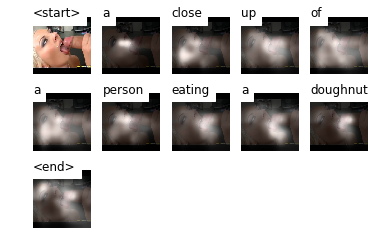

In [29]:
img_path = '/home/a-PyTorch-Tutorial-to-Image-Captioning/download.jpg'
seq, alphas = caption_image_beam_search(encoder, decoder,img_path , word_map,5 )
alphas = torch.FloatTensor(alphas)
visualize_att(img_path, seq, alphas, rev_word_map)

In [30]:
words = [rev_word_map[ind] for ind in seq]

In [31]:
print(words)

['<start>', 'a', 'close', 'up', 'of', 'a', 'person', 'eating', 'a', 'doughnut', '<end>']
